# Tugas Praktikum: Multiple Linear Regression – Medical Cost Personal Datasets (insurance.csv)

Dataset berisi biaya medis individu dan faktor demografis/perilaku:
- age (int): usia
- sex (category): jenis kelamin (female/male)
- bmi (float): Body Mass Index
- children (int): jumlah tanggungan/anak
- smoker (category): perokok (yes/no)
- region (category): wilayah tempat tinggal (northeast/northwest/southeast/southwest)
- charges (float): total biaya medis (TARGET)

Tujuan: bangun model Multiple Linear Regression untuk memprediksi `charges` dari fitur di atas; evaluasi dengan R², MSE, dan MAE; tampilkan visualisasi pendukung (korelasi, scatter, residual).

# Imports & Load Data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility
RANDOM_STATE = 42

# Load dataset (notebook berada di folder yang sama dengan file)
DATA_PATH = Path('insurance.csv')
df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('\nHead:')
display(df.head())

print('\nMissing values per column:')
print(df.isna().sum())

Shape: (1338, 7)

Head:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"



Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# EDA Ringkas: deskripsi, korelasi, dan plot

Deskripsi numerik:


,age,bmi,children,charges
count,"1,338.00","1,338.00","1,338.00","1,338.00"
mean,39.21,30.66,1.09,"13,270.42"
std,14.05,6.10,1.21,"12,110.01"
min,18.00,15.96,0.00,"1,121.87"
25%,27.00,26.30,0.00,"4,740.29"
50%,39.00,30.40,1.00,"9,382.03"
75%,51.00,34.69,2.00,"16,639.91"
max,64.00,53.13,5.00,"63,770.43"



Distribusi kategori:

sex:
sex
male      676
female    662
Name: count, dtype: int64

smoker:
smoker
no     1064
yes     274
Name: count, dtype: int64

region:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


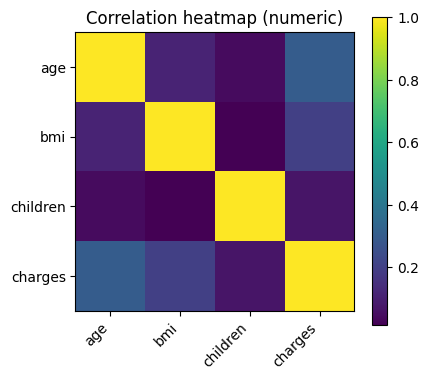

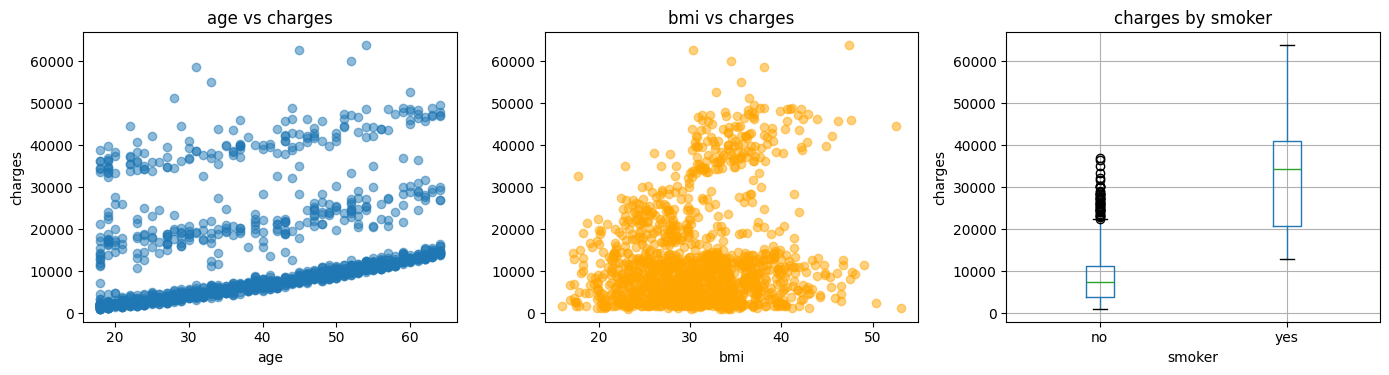

In [18]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print('Deskripsi numerik:')
display(df[['age','bmi','children','charges']].describe())

print('\nDistribusi kategori:')
for col in ['sex','smoker','region']:
    print(f'\n{col}:')
    print(df[col].value_counts())

# Korelasi numerik
corr = df[['age','bmi','children','charges']].corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(4.5,4))
cax = ax.imshow(corr, cmap='viridis')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
fig.colorbar(cax, ax=ax)
ax.set_title('Correlation heatmap (numeric)')
plt.show()

# Scatter beberapa fitur vs charges
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].scatter(df['age'], df['charges'], alpha=0.5)
axes[0].set_xlabel('age'); axes[0].set_ylabel('charges'); axes[0].set_title('age vs charges')

axes[1].scatter(df['bmi'], df['charges'], alpha=0.5, color='orange')
axes[1].set_xlabel('bmi'); axes[1].set_title('bmi vs charges')

# Boxplot charges by smoker
df.boxplot(column='charges', by='smoker', ax=axes[2])
axes[2].set_title('charges by smoker')
axes[2].set_xlabel('smoker'); axes[2].set_ylabel('charges')
plt.suptitle('')
plt.tight_layout()
plt.show()

# Preprocessing, Split, dan Training Model (Multiple Linear Regression)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Fitur dan target
features_num = ['age', 'bmi', 'children']
features_cat = ['sex', 'smoker', 'region']
X = df[features_num + features_cat]
y = df['charges']

# Preprocessor: scale numerik (opsional) + one-hot encode kategori 
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_num),
        ('cat', categorical_transformer, features_cat)
    ],
    remainder='drop'
)

# Pipeline: preprocess -> linear regression
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Fit model
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi: R2, MSE, MAE + Visualisasi

R-squared  : 0.7836
MSE        : 33,596,915.85
MAE        : 4,181.19


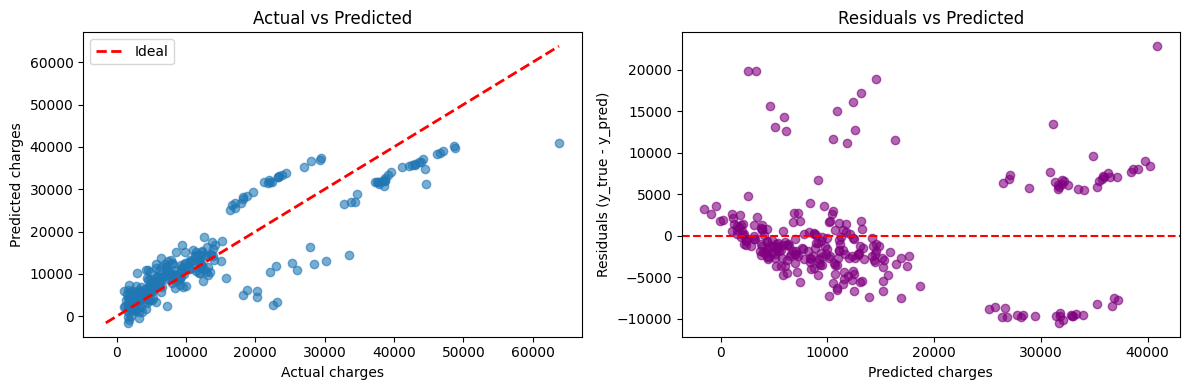

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R-squared  : {r2:.4f}')
print(f'MSE        : {mse:,.2f}')
print(f'MAE        : {mae:,.2f}')

# Plot y_true vs y_pred
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].scatter(y_test, y_pred, alpha=0.6)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
ax[0].plot([min_v, max_v], [min_v, max_v], 'r--', lw=2, label='Ideal')
ax[0].set_xlabel('Actual charges')
ax[0].set_ylabel('Predicted charges')
ax[0].set_title('Actual vs Predicted')
ax[0].legend()

# Residuals
residuals = y_test - y_pred
ax[1].scatter(y_pred, residuals, alpha=0.6, color='purple')
ax[1].axhline(0, color='r', linestyle='--')
ax[1].set_xlabel('Predicted charges')
ax[1].set_ylabel('Residuals (y_true - y_pred)')
ax[1].set_title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

In [21]:
# Koefisien fitur (di ruang fitur yang telah dipreproses)
import numpy as np

pre = model.named_steps['preprocess']
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    # Fallback untuk versi sklearn lama
    feature_names = []
    # Num
    feature_names += [f'num__{c}' for c in features_num]
    # Cat (OneHotEncoder drop='first' menghasilkan n-1 kolom per fitur kategori)
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    cat_names = []
    for col, cats in zip(features_cat, ohe.categories_):
        cat_names += [f'{col}_{c}' for c in cats[1:]]
    feature_names += [f'cat__{n}' for n in cat_names]

coefs = model.named_steps['model'].coef_
coef_table = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

print('Top 10 fitur berdasarkan |koefisien|:')
display(coef_table.head(10))

if not coef_table.empty:
    top_feat = coef_table.iloc[0]
    print(f"Fitur paling berpengaruh (menurut |coef|): {top_feat['feature']} dengan koefisien {top_feat['coef']:.3f}")

Top 10 fitur berdasarkan |koefisien|:


,feature,coef,abs_coef
4,cat__smoker_yes,"23,651.13","23,651.13"
0,num__age,"3,614.98","3,614.98"
1,num__bmi,"2,036.23","2,036.23"
7,cat__region_southwest,-809.80,809.80
6,cat__region_southeast,-657.86,657.86
2,num__children,516.89,516.89
5,cat__region_northwest,-370.68,370.68
3,cat__sex_male,-18.59,18.59


Fitur paling berpengaruh (menurut |coef|): cat__smoker_yes dengan koefisien 23651.129


## Analisis Hasil (Ringkas)

- Pipeline pra-pemrosesan: standardisasi fitur numerik (`age`, `bmi`, `children`) dan One-Hot Encoding untuk kategori (`sex`, `smoker`, `region`, drop='first').
- Split data: 80% train, 20% test (random_state=42).
- Model: Multiple Linear Regression (Scikit-Learn).
- Arah tanda koefisien menunjukkan pengaruh naik/turun pada charges, besarnya |koefisien| menunjukkan kekuatan pengaruh di ruang fitur terstandarisasi/ter-encode.

Hasil evaluasi pada data uji:
- R² ≈ 0.784 — model menjelaskan ~78% variasi `charges`.
- MSE ≈ 33.6 juta; MAE ≈ 4.18 ribu — rata-rata kesalahan absolut sekitar 4.2k.

Interpretasi:
- Fitur paling kuat: status perokok (`smoker_yes`) dengan koefisien positif sangat besar, diikuti usia (`age`) dan BMI (`bmi`).
- Beberapa wilayah (`region`) memiliki koefisien negatif kecil terhadap `charges` dibanding baseline.
- Plot residual menunjukkan pola non-linear ringan (terutama pada kelompok perokok vs non-perokok); model linear menangkap tren utama namun masih ada struktur sisa.